# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [18]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

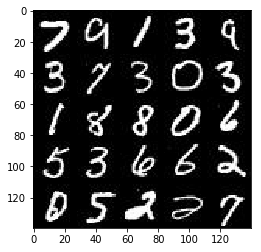

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

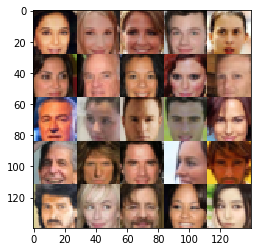

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [22]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_images') 
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
   
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [23]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    image_size = 28
    s2, s4, s8, s16 = int(image_size/2), int(image_size/4), int(image_size/8), int(image_size/16)
    df_dim = 64
    #print('images:', images.shape)
    with tf.variable_scope('discriminator', reuse=reuse):
        d1 = tf.layers.conv2d(images, df_dim , 5, strides=2, padding='same')
        d1_relu = tf.maximum(alpha * d1, d1)
        d1_drop = tf.layers.dropout(d1_relu, 0.3)
        
        d2 = tf.layers.conv2d(d1_drop, df_dim*2, 5, strides=2, padding='same')
        d2_bn = tf.layers.batch_normalization(d2, training=True)
        d2_relu = tf.maximum(alpha * d2_bn, d2_bn)
        d2_drop = tf.layers.dropout(d2_relu, 0.3)
        
        d3 = tf.layers.conv2d(d2_drop, df_dim*4, 5, strides=2, padding='same')
        d3_bn = tf.layers.batch_normalization(d3, training=True)
        d3_relu = tf.maximum(alpha * d3_bn, d3_bn)
        d3_drop = tf.layers.dropout(d3_relu, 0.3)
        
        d4 = tf.layers.conv2d(d3_drop, df_dim*8, 5, strides=2, padding='same')
        d4_bn = tf.layers.batch_normalization(d3, training=True)
        d4_relu = tf.maximum(alpha * d4_bn, d4_bn)
        d4_drop = tf.layers.dropout(d4_relu, 0.3)

        
        flat = tf.reshape(d3_relu, (-1, 4*4*df_dim*8)) 
        #print ('flat:',flat.shape)
        logits = tf.layers.dense(flat, 1)
        dropout4 = tf.layers.dropout(logits, 0.3)
        
        #print ('logits:',logits.shape)
        out = tf.sigmoid(logits)
        
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    
    """
    image_size = 28
    s2, s4, s8, s16 = int(image_size/2), int(image_size/4), int(image_size/8), int(image_size/16)
    gf_dim = 64
    
    with tf.variable_scope("generator", reuse=not is_train):
        #print('z:', z.shape)
        #print('out_channel_dim:', out_channel_dim.shape)
        # First fully connected layer
        
        g1 = tf.layers.dense(z, gf_dim*8*4*4)
        g1_drop2 = tf.layers.dropout(g1, 0.3)
        #print("g1:", g1.shape)
        
        # Reshape it to start the convolutional stack
        g1_flat = tf.reshape(g1_drop2, (-1, 4, 4, gf_dim*8))
        g1_bn = tf.layers.batch_normalization(g1_flat,  training=is_train)
        g1_relu = tf.maximum(alpha * g1_bn, g1_bn)
        #print ('g1_relu:',g1_relu.shape)
        
        
        g2 = tf.layers.conv2d_transpose(g1_relu, gf_dim*4 ,(4,4), strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        g2_bn = tf.layers.batch_normalization(g2, training=is_train)
        g2_relu = tf.maximum(alpha * g2_bn, g2_bn)
        #print ('g2_relu:',g2_relu.shape)
        
        g3 = tf.layers.conv2d_transpose(g2_relu,gf_dim*2, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        g3_bn = tf.layers.batch_normalization(g3, training=is_train)
        g3_relu = tf.maximum(alpha * g3_bn, g3_bn)
        #print ('g3_relu:',g3_relu.shape)
        
        g4 = tf.layers.conv2d_transpose(g3_relu,gf_dim, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        g4_bn = tf.layers.batch_normalization(g4, training=is_train)
        g4_relu = tf.maximum(alpha * g4_bn, g4_bn)
        #print ('g4_relu:',g4_relu.shape)
        
    
        # Output layer
        logits = tf.layers.conv2d_transpose(g4_relu, out_channel_dim, (5,5), strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #print ('Logit:',logits.shape)
        logits = tf.image.resize_images(logits, (28,28))
        #print ('Logit:',logits.shape)
        out = tf.tanh(logits)
        #print ('out:',out.shape)
        return out
       



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss
    
   
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """ # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")

    """
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 50 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0849... Generator Loss: 7.8077
Epoch 1/2... Discriminator Loss: 0.3884... Generator Loss: 14.2357
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.4597
Epoch 1/2... Discriminator Loss: 0.0884... Generator Loss: 3.2084
Epoch 1/2... Discriminator Loss: 0.0387... Generator Loss: 3.9585


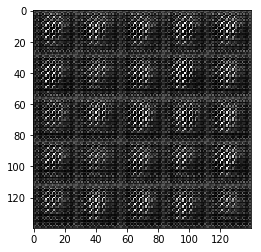

Epoch 1/2... Discriminator Loss: 0.0341... Generator Loss: 6.2601
Epoch 1/2... Discriminator Loss: 0.3866... Generator Loss: 1.2755
Epoch 1/2... Discriminator Loss: 0.0362... Generator Loss: 7.5029
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 7.8993
Epoch 1/2... Discriminator Loss: 0.1558... Generator Loss: 2.6479


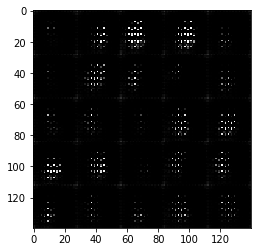

Epoch 1/2... Discriminator Loss: 0.1836... Generator Loss: 2.5192
Epoch 1/2... Discriminator Loss: 0.0242... Generator Loss: 10.7039
Epoch 1/2... Discriminator Loss: 0.5701... Generator Loss: 1.4305
Epoch 1/2... Discriminator Loss: 0.2225... Generator Loss: 2.6273
Epoch 1/2... Discriminator Loss: 0.3059... Generator Loss: 3.6306


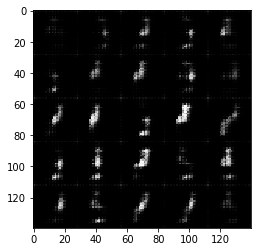

Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 1.6626
Epoch 1/2... Discriminator Loss: 0.1733... Generator Loss: 3.9190
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 2.4781... Generator Loss: 0.1624
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.9327


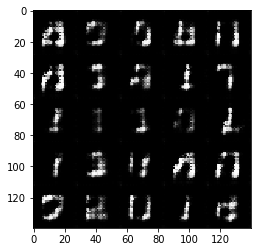

Epoch 1/2... Discriminator Loss: 0.1806... Generator Loss: 2.8286
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.9127... Generator Loss: 4.7037
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 3.2650
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 1.7817


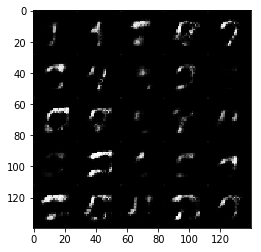

Epoch 1/2... Discriminator Loss: 2.7758... Generator Loss: 0.1210
Epoch 1/2... Discriminator Loss: 0.6282... Generator Loss: 1.5892
Epoch 1/2... Discriminator Loss: 1.8509... Generator Loss: 3.2647
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 2.4042
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 3.7580


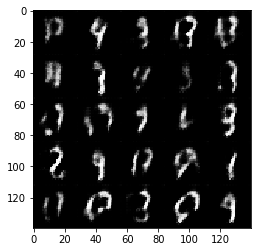

Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 1.4146
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.8980


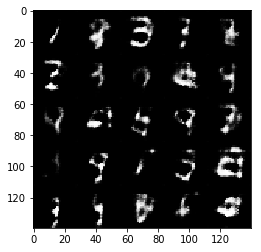

Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.9713
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.4028
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 0.8015


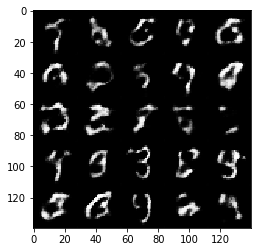

Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 3.0700... Generator Loss: 5.1283
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 1.1695


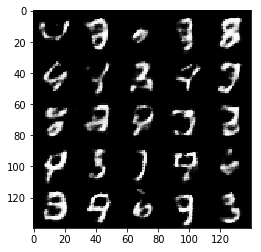

Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.4472
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 1.6029


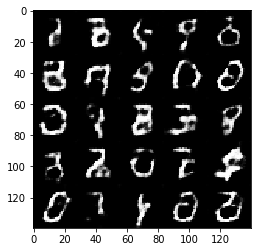

Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 1.3863
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.3754
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 1.0568


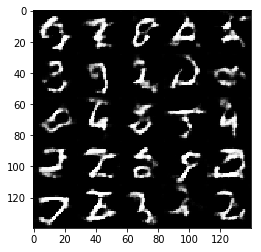

Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 1.6445
Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.2690
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.3920
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.2394


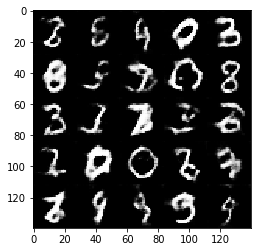

Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.8965
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 1.0438
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.5802


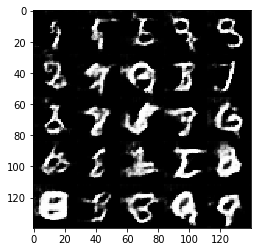

Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 1.1245
Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 1.0924
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.5418
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 1.2646


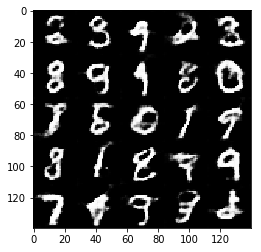

Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.1817
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 1.3027
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 1.5723
Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.5359


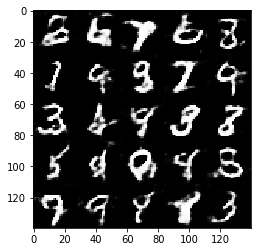

Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 0.8587... Generator Loss: 1.2930
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 1.3854


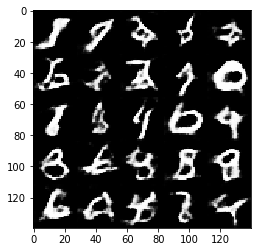

Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 1.4866
Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 1.2822
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 1.0015
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 1.4752
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.8001


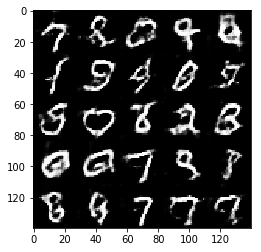

Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.3100
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 1.2778


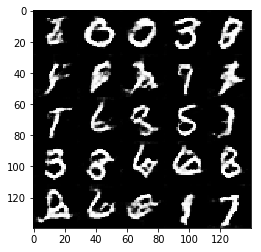

Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 1.2103
Epoch 1/2... Discriminator Loss: 0.8214... Generator Loss: 1.0080
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.4920
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.4614


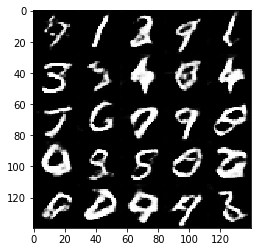

Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 1.4646
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.2209... Generator Loss: 1.7592
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 1.2340
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.3989


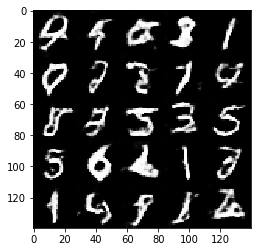

Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.9138


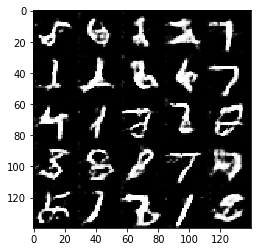

Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.4541
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 0.7662


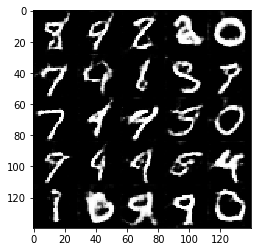

Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 0.4836
Epoch 2/2... Discriminator Loss: 2.0429... Generator Loss: 0.1686
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.7508
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.3656


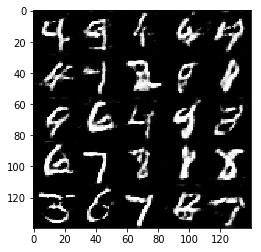

Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 0.9914
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 1.4676
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 2.0744... Generator Loss: 0.1739


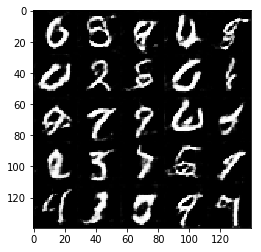

Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.5329
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 0.8954... Generator Loss: 1.1024
Epoch 2/2... Discriminator Loss: 0.9718... Generator Loss: 0.6764


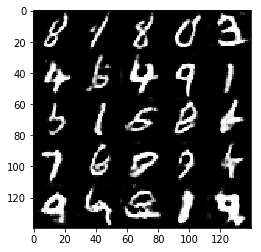

Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 2.4073
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 1.0888
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.1821
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 0.6097


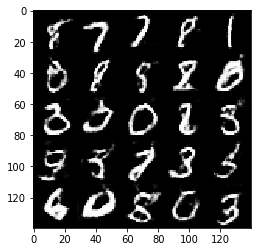

Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.4425
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 1.1267
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 1.8404... Generator Loss: 0.2113


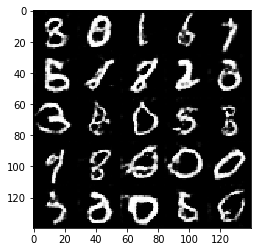

Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 1.1902
Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 0.6046


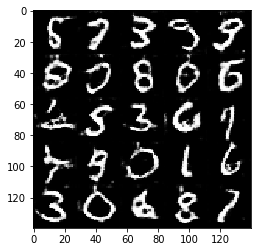

Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 1.4508
Epoch 2/2... Discriminator Loss: 0.9095... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 0.8568
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 0.7708


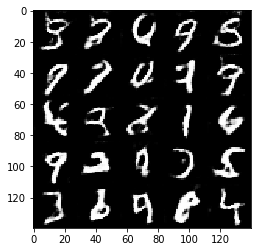

Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.2029
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.1810
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.6502
Epoch 2/2... Discriminator Loss: 1.4996... Generator Loss: 1.8446


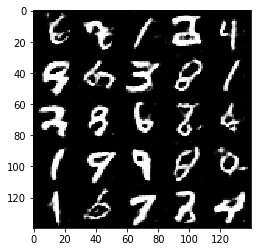

Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.3819
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.9379
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 0.9097


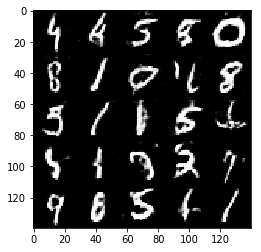

Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.3964
Epoch 2/2... Discriminator Loss: 1.8319... Generator Loss: 0.2346
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 1.0491


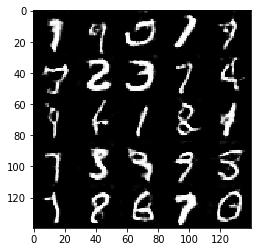

Epoch 2/2... Discriminator Loss: 1.4211... Generator Loss: 0.3505
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.3764
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 0.6839


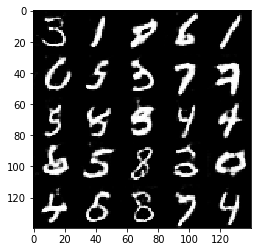

Epoch 2/2... Discriminator Loss: 2.6243... Generator Loss: 4.4216
Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.4726
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.4928
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 0.5546


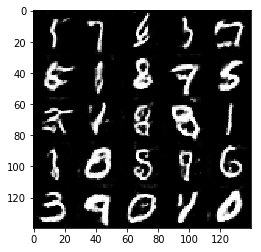

Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.4637
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.4272
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 1.7303
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.4242


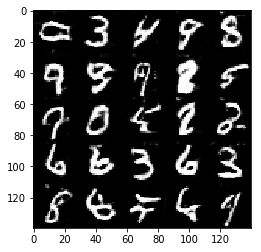

Epoch 2/2... Discriminator Loss: 0.8350... Generator Loss: 1.3148
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 2.6897... Generator Loss: 3.9115
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.5026... Generator Loss: 0.4043


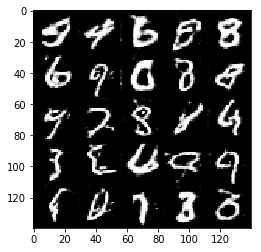

Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.4321
Epoch 2/2... Discriminator Loss: 1.8550... Generator Loss: 0.2191
Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 1.3021
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.4075
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.4574


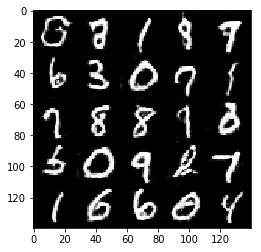

Epoch 2/2... Discriminator Loss: 1.8394... Generator Loss: 0.2308
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.8059


In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs =2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4325... Generator Loss: 0.1177
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 15.3708
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 7.4140
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.3019
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 4.5991


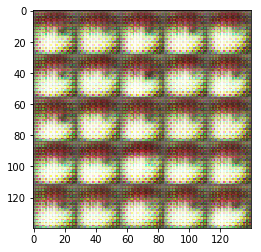

Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 13.5813
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 11.8758
Epoch 1/1... Discriminator Loss: 2.5793... Generator Loss: 0.0992
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 11.9732
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 8.8280


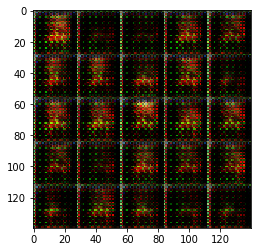

Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 7.5986
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 2.3292
Epoch 1/1... Discriminator Loss: 0.1482... Generator Loss: 2.6408


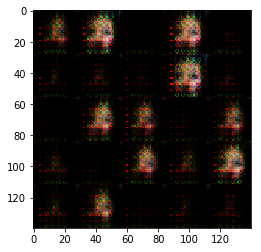

Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 4.5940
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.9787
Epoch 1/1... Discriminator Loss: 0.3243... Generator Loss: 5.1834
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 2.9153
Epoch 1/1... Discriminator Loss: 0.1973... Generator Loss: 2.0242


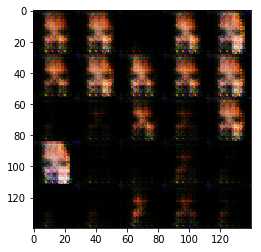

Epoch 1/1... Discriminator Loss: 2.1116... Generator Loss: 0.1748
Epoch 1/1... Discriminator Loss: 2.5506... Generator Loss: 0.1246
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 2.3355
Epoch 1/1... Discriminator Loss: 2.3848... Generator Loss: 4.6192
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.4002


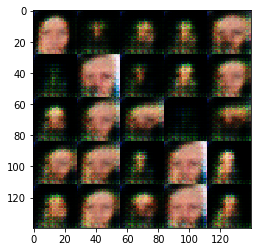

Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4065
Epoch 1/1... Discriminator Loss: 3.0673... Generator Loss: 5.0781
Epoch 1/1... Discriminator Loss: 0.2623... Generator Loss: 2.8646


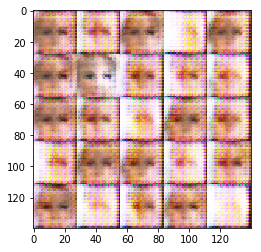

Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 1.7068
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 2.3596


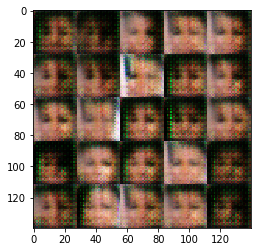

Epoch 1/1... Discriminator Loss: 2.2261... Generator Loss: 0.3062
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.9316
Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 2.1936
Epoch 1/1... Discriminator Loss: 2.0495... Generator Loss: 2.3074
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.2973


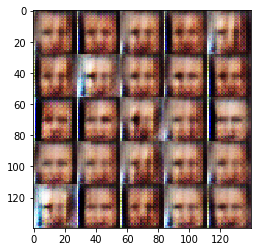

Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 1.7614... Generator Loss: 0.5235


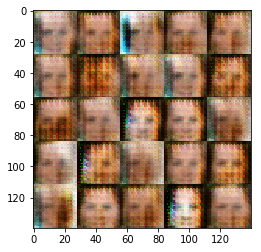

Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.7640... Generator Loss: 0.3082
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 2.4239
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 1.1491


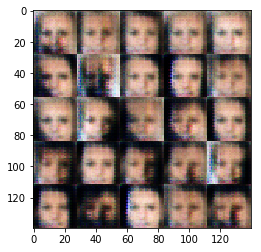

Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 2.8262
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.5653


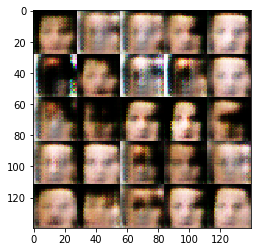

Epoch 1/1... Discriminator Loss: 1.6507... Generator Loss: 0.4020
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.7667
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.2968


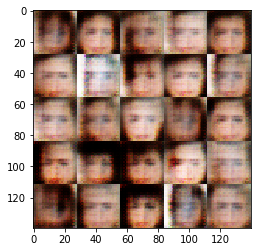

Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 2.5470
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.6321


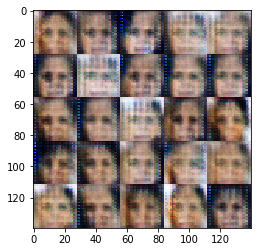

Epoch 1/1... Discriminator Loss: 0.3158... Generator Loss: 2.2889
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 3.0041
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 1.3566


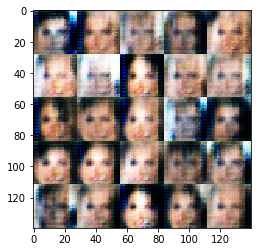

Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 2.0639
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.2094


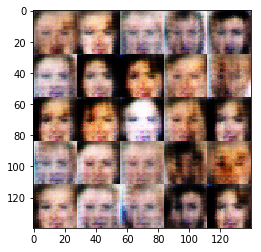

Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.2902
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 1.6696


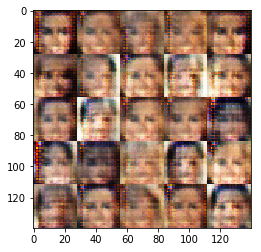

Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.8890... Generator Loss: 0.2278
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.5283


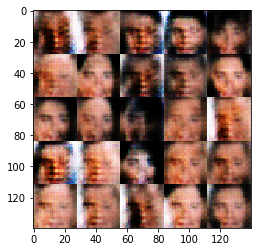

Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.7408


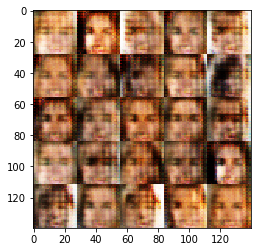

Epoch 1/1... Discriminator Loss: 2.1797... Generator Loss: 0.1958
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.9190
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.5999


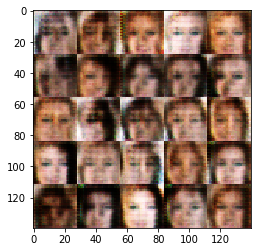

Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.5377


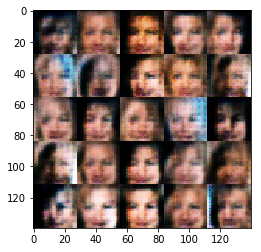

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.3234


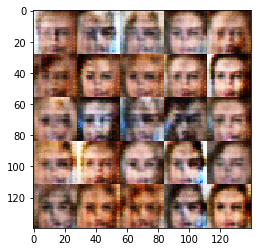

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 0.2639


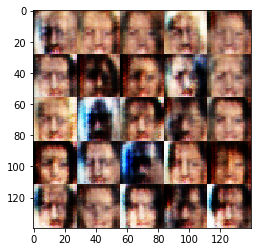

Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 2.4871
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.5226


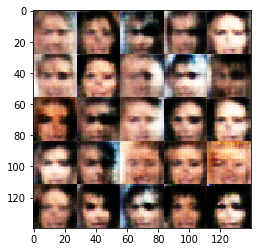

Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.1569


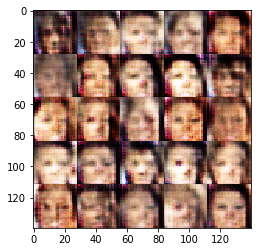

Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 2.0756
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 1.8495
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.0613


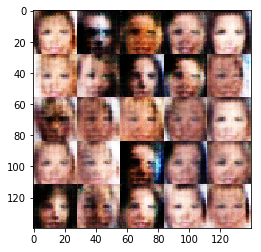

Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 1.7220
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 2.9472
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.3396


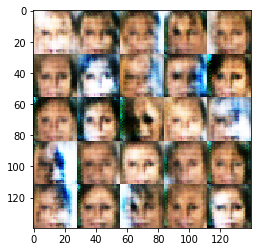

Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 1.9382
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.5822
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7524


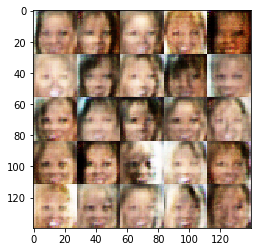

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.7429... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 2.2401
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 1.6318
Epoch 1/1... Discriminator Loss: 1.9787... Generator Loss: 0.2092


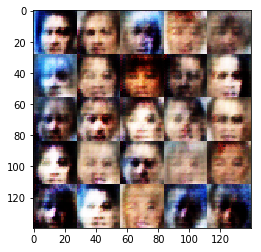

Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 2.5436
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.9489
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.0183


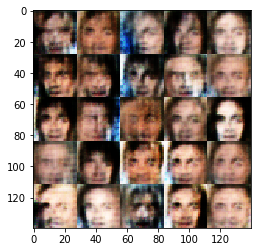

Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.8020... Generator Loss: 0.3038
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6037


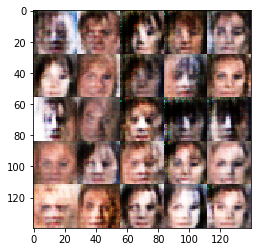

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 2.2657
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.4694


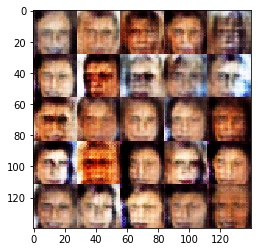

Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.8010
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.9709


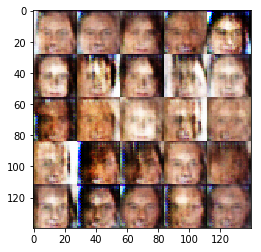

Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.8217
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.7132


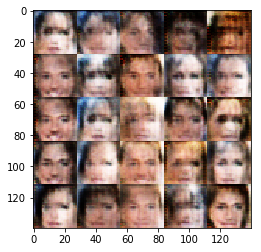

Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.2378


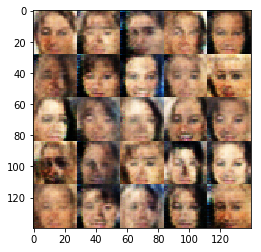

Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 2.0487... Generator Loss: 2.7363
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.4867


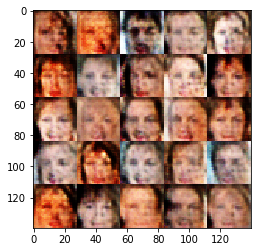

Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.3449


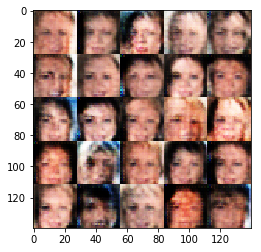

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 2.6550
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.5799


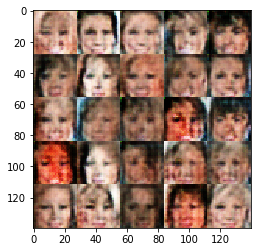

Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.6805
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.3729


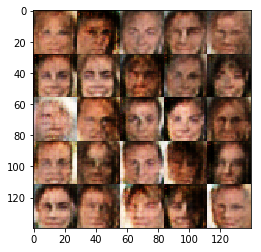

Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.3771
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.2672


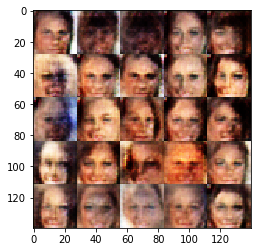

Epoch 1/1... Discriminator Loss: 1.7094... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.4774


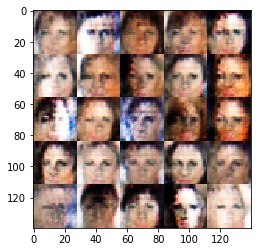

Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.8513
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 2.0868
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6982


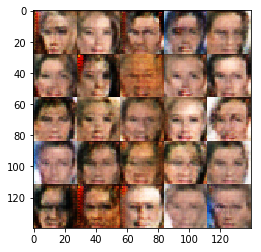

Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 1.5967
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.4808


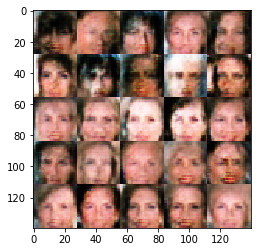

Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.4009


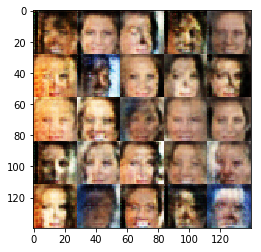

Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 2.2144... Generator Loss: 0.1594
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.8180
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.0703


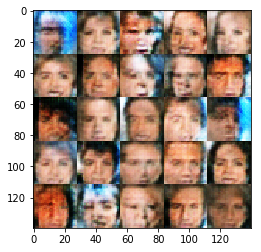

Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.3456


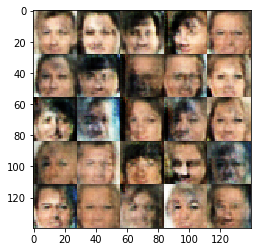

Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.6703


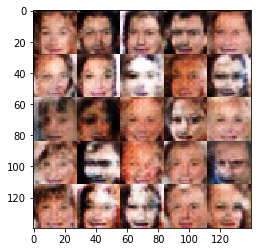

Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 2.4190


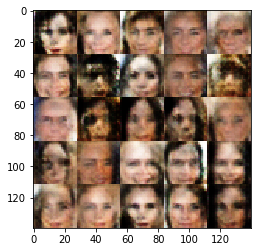

Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.7673
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.6709


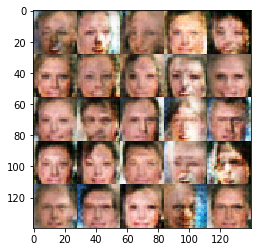

Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.0409


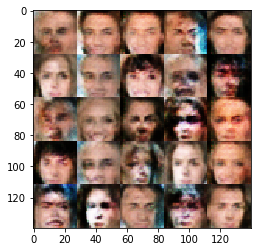

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 1.6835
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9740


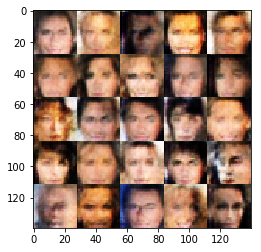

Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.3200
Epoch 1/1... Discriminator Loss: 2.1777... Generator Loss: 3.3022
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.6171


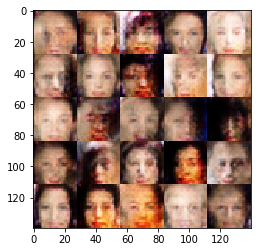

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.8373


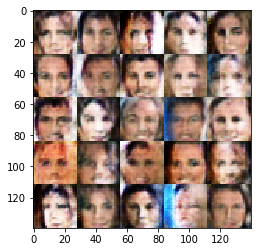

Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.9741
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.2472


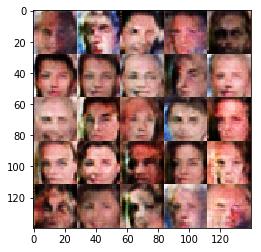

Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.5975


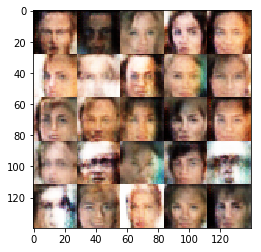

Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7295


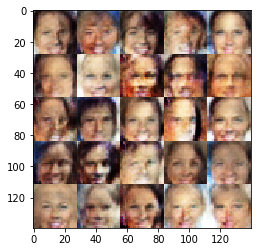

Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 1.7105
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.1996


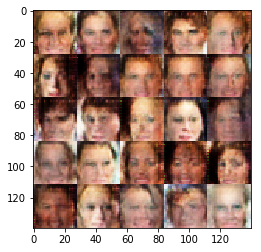

Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.3889
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.3686


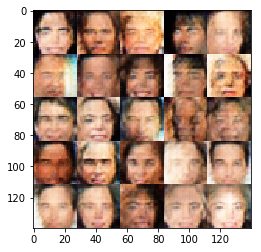

Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 1.9267
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.6149


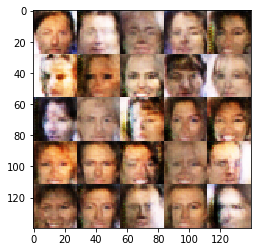

Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.1961


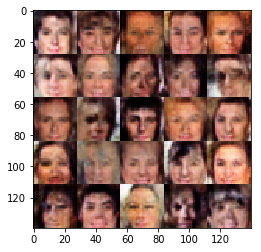

Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.9227


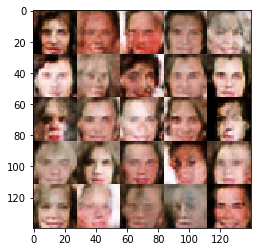

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.0149


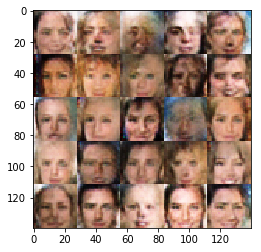

Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.7253


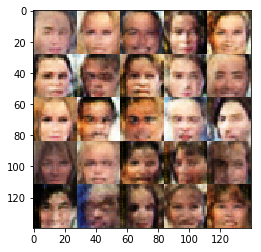

Epoch 1/1... Discriminator Loss: 1.7773... Generator Loss: 0.2519
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.5029


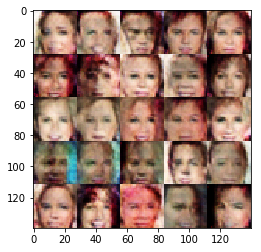

Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.4408


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.